<a href="https://colab.research.google.com/github/alitvintsev/nn-models/blob/master/03_pytorch_intro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyTorch Intro

In [1]:
from glob import glob
import shutil
import os
import sys
import time
import tarfile
import matplotlib.pyplot as plt
import numpy as np
import json
import torch
import torchvision
from sklearn.datasets import load_boston
from IPython.display import clear_output
from six.moves.urllib.request import urlretrieve
from matplotlib.pyplot import imread
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset, Subset

In [2]:
! mkdir ~/.kaggle
! touch ~/.kaggle/kaggle.json

api_token = {"username":"alitvintsev","key":"68093372c6ecb30b6f6b50d18e683cd2"}

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

! chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [3]:
def load_notmnist(
    path="./notMNIST_small", letters="ABCDEFGHIJ", img_shape=(28, 28), test_size=0.25, one_hot=False
):
 
    # download data if it's missing. If you have any problems, go to the urls and load it manually.
    if not os.path.exists(path):
        if not os.path.exists("./notMNIST_small.tar.gz"):
            print("Downloading data...")
            assert (
                os.system(
                    "curl http://yaroslavvb.com/upload/notMNIST/notMNIST_small.tar.gz > notMNIST_small.tar.gz"
                )
                == 0
            )
        print("Extracting ...")
        assert os.system("tar -zxvf notMNIST_small.tar.gz > untar_notmnist.log") == 0
 
    data, labels = [], []
    print("Parsing...")
    for img_path in glob(os.path.join(path, "*/*")):
        class_i = img_path.split(os.sep)[-2]
        if class_i not in letters:
            continue
        try:
            data.append(imread(img_path))
            labels.append(
                class_i,
            )
        except BaseException:
            print("found broken img: %s [it's ok if <10 images are broken]" % img_path)
 
    data = np.stack(data)[:, None].astype("float32")
    data = (data - np.mean(data)) / np.std(data)
 
    # convert classes to ints
    letter_to_i = {l: i for i, l in enumerate(letters)}
    labels = np.array(list(map(letter_to_i.get, labels)))
 
    if one_hot:
        labels = (np.arange(np.max(labels) + 1)[None, :] == labels[:, None]).astype("float32")
 
    # split into train/test
    X_train, X_test, y_train, y_test = train_test_split(
        data, labels, test_size=test_size, random_state=42
    )
 
    print("Done")
    return X_train, y_train, X_test, y_test

### Pipeline

In [4]:
df_boston = load_boston()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (i.e.

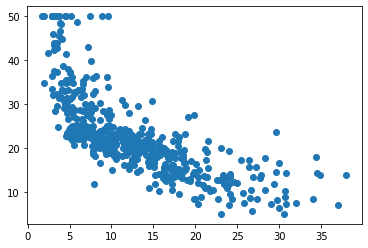

In [5]:
plt.scatter(df_boston.data[:, -1], df_boston.target)

In [6]:
w = torch.zeros(1, requires_grad=True)
b = torch.zeros(1, requires_grad=True)

In [7]:
x = torch.tensor(df_boston.data[:, -1] / 10, dtype=torch.float32)
y = torch.tensor(df_boston.target, dtype=torch.float32)

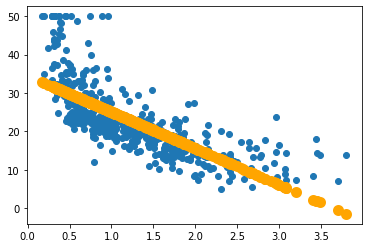

loss =  38.48297


In [8]:
losses = []
n_epochs = 500
lr = 0.05

for i in range(n_epochs):
    # forward
    y_pred = w * x + b
    loss = torch.mean((y_pred - y) ** 2)
    losses.append(loss.item())

    # backward
    loss.backward()

    # update
    w.data -= lr * w.grad.data
    b.data -= lr * b.grad.data 

    # zero gradients
    w.grad.data.zero_()
    b.grad.data.zero_()

    # plot
    if (i + 1) % 5 == 0:
        clear_output(True)
        plt.scatter(x.data.numpy(), y.data.numpy())
        plt.scatter(x.data.numpy(), y_pred.data.numpy(), color='orange', linewidths=5)
        plt.show()

        print('loss = ', loss.data.numpy())

        if loss.data.numpy() < 0.5:
            print('Done!')
            break


## High-Level PyTorch

In [9]:
! kaggle datasets download -d quanbk/notmnist

notmnist.zip: Skipping, found more recently modified local copy (use --force to force download)


In [10]:
! unzip notmnist.zip && ls -l

Archive:  notmnist.zip
replace notMNIST_large.tar.gz? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
total 499692
drwxr-xr-x 12 root root      4096 Sep 18 15:58 notMNIST_large
-rw-r--r--  1 root root 247336696 Nov 21  2019 notMNIST_large.tar.gz
drwxr-xr-x 12 root root      4096 Sep 18 15:58 notMNIST_small
-rw-r--r--  1 root root   8458043 Nov 21  2019 notMNIST_small.tar.gz
-rw-r--r--  1 root root 255877061 Sep 18 15:56 notmnist.zip
drwxr-xr-x  1 root root      4096 Sep 14 13:44 sample_data


In [11]:
num_classes = 10
np.random.seed(133)

def move_files(source_dir, target_dir):
    print(source_dir)
    print(target_dir)
    file_names = os.listdir(source_dir)
    for file_name in file_names:
        shutil.move(os.path.join(source_dir, file_name), target_dir)
    shutil.rmtree(source_dir)


def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  print(root)
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall(root)
    tar.close()
  
  source_dir = root + '/' + root[2:]
  move_files(source_dir, root)

  data_folders = [
    os.path.join(root, d) for d in sorted(os.listdir(root))
    if os.path.isdir(os.path.join(root, d))]
  if len(data_folders) != num_classes:
    raise Exception(
      'Expected %d folders, one per class. Found %d instead.' % (
        num_classes, len(data_folders)))
  print(data_folders)
  return data_folders

In [12]:
train_filename = './notMNIST_large.tar.gz'
test_filename = './notMNIST_small.tar.gz'

In [13]:
! ls -l notMNIST_large/

total 30440
drwxrwxr-x 2 133040 5000 3117056 Aug  9  2011 A
drwxrwxr-x 2 133040 5000 3117056 Aug  9  2011 B
drwxrwxr-x 2 133040 5000 3117056 Aug  9  2011 C
drwxrwxr-x 2 133040 5000 3117056 Aug  9  2011 D
drwxrwxr-x 2 133040 5000 3117056 Aug  9  2011 E
drwxrwxr-x 2 133040 5000 3117056 Aug  9  2011 F
drwxrwxr-x 2 133040 5000 3117056 Aug  9  2011 G
drwxrwxr-x 2 133040 5000 3117056 Aug  9  2011 H
drwxrwxr-x 2 133040 5000 3117056 Aug  9  2011 I
drwxrwxr-x 2 133040 5000 3117056 Aug  9  2011 J


In [ ]:
train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)

In [16]:
characters = 'abcdefghij'.upper()  # sub folders to choose images from 
image_per_folder = 4 # number of images to show for each folder

In [17]:
BASE_PATH = './notMNIST_small/'

list_of_images = []
for _ in range(image_per_folder):
    for char in characters:
        char_folder = BASE_PATH + char + '/'
        images = os.listdir(char_folder)
        image_file_name = images[np.random.randint(len(images))]
        list_of_images.append(char_folder + image_file_name)
    

def showImagesHorizontally(list_of_files):
    from matplotlib.pyplot import figure, imshow, axis
    from matplotlib.image import imread
    
    number_of_files = len(list_of_files)
    num_char = len(characters)
    
    for row in range(int(number_of_files/num_char)):
        fig = figure(figsize=(15, 5))
        
        for i in range(num_char):
            a = fig.add_subplot(1, num_char, i + 1)
            image = imread(list_of_files[row * num_char + i])
            imshow(image, cmap='gray')
            axis('off')

In [18]:
X_train, y_train, X_test, y_test = load_notmnist(letters='AB')
X_train, X_test = X_train.reshape([-1, 784]), X_test.reshape([-1, 784])

Parsing...
found broken img: ./notMNIST_small/A/RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png [it's ok if <10 images are broken]
Done


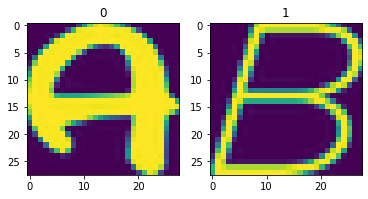

In [19]:
for i in [0, 1]:
  plt.subplot(1, 2, i + 1)
  plt.imshow(X_train[i].reshape([28, 28]))
  plt.title(str(y_train[i]))

In [20]:
from torch import nn
import torch.nn.functional as F

In [21]:
print(nn.Module.__doc__)

Base class for all neural network modules.

    Your models should also subclass this class.

    Modules can also contain other Modules, allowing to nest them in
    a tree structure. You can assign the submodules as regular attributes::

        import torch.nn as nn
        import torch.nn.functional as F

        class Model(nn.Module):
            def __init__(self):
                super().__init__()
                self.conv1 = nn.Conv2d(1, 20, 5)
                self.conv2 = nn.Conv2d(20, 20, 5)

            def forward(self, x):
                x = F.relu(self.conv1(x))
                return F.relu(self.conv2(x))

    Submodules assigned in this way will be registered, and will have their
    parameters converted too when you call :meth:`to`, etc.

    .. note::
        As per the example above, an ``__init__()`` call to the parent class
        must be made before assignment on the child.

    :ivar training: Boolean represents whether this module is in training or
         

### Create model

In [22]:
model = nn.Sequential(nn.Linear(784, 1), nn.Sigmoid())

In [23]:
print('Weight shapes: ', [w.shape for w in model.parameters()])

Weight shapes:  [torch.Size([1, 784]), torch.Size([1])]


In [24]:
learning_rate = 0.01
opt = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [25]:
batch_size = 256

history = []

for i in range(100):
    ix = np.random.randint(0, len(X_train), batch_size)
    x_batch = torch.tensor(X_train[ix], dtype=torch.float32)
    y_batch = torch.tensor(y_train[ix], dtype=torch.float32)

    y_predicted = model(x_batch)[:, 0]

    crossentropy = F.binary_cross_entropy(y_predicted, y_batch, reduction='none')

    loss = torch.mean(crossentropy, dim=0, keepdim=True)

    loss.backward()

    opt.step()

    opt.zero_grad()

    history.append(loss.item())

    if i % 10 == 0:
        print('Step: {}, Mean loss: {}'.format(i, np.mean(history[-10:])))

Step: 0, Mean loss: 0.8184692859649658
Step: 10, Mean loss: 0.36094728112220764
Step: 20, Mean loss: 0.22329979240894318
Step: 30, Mean loss: 0.1785984143614769
Step: 40, Mean loss: 0.16262853890657425
Step: 50, Mean loss: 0.14645501375198364
Step: 60, Mean loss: 0.1259693630039692
Step: 70, Mean loss: 0.12141789421439171
Step: 80, Mean loss: 0.11140520647168159
Step: 90, Mean loss: 0.11616774946451187


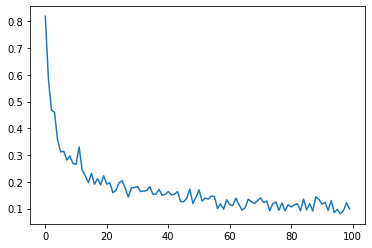

In [26]:
plt.plot(history)

## Optimization and Regularization

In [27]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cpu')

In [28]:
class DatasetMNIST(Dataset):
  def __init__(self, path='./notMNIST_small', letters='ABCDEFGHIJ', transform=None):
    self.data, self.labels, _, _ = load_notmnist(path=path, letters=letters, test_size=0.2)
    self.transform = transform

  def __len__(self):
    return len(self.data)

  def __getitem__(self, index):
    image = self.data[index].transpose(1, 2, 0)
    label = self.labels[index]

    if self.transform is not None:
      image = self.transform(image)

    return image, label

In [29]:
full_dataset = DatasetMNIST(path='./notMNIST_small', letters='AB')

Parsing...
found broken img: ./notMNIST_small/A/RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png [it's ok if <10 images are broken]
Done


In [30]:
class Flatten:
    def __call__(self, pic):
        return pic.flatten()

    def __repr__(self):
        return self.__class__.__name__ + '()'

In [41]:
transforms = torchvision.transforms.Compose([
    # torchvision.transforms.CenterCrop(size=14),
    # torchvision.transforms.Resize((640, 460)),
    torchvision.transforms.ToTensor(),
    Flatten()
])

In [42]:
loss_fn = nn.CrossEntropyLoss()

In [43]:
def subset_inds(dataset, ratio: float):
    return np.random.choice(len(dataset), size=int(ratio * len(dataset)), replace=False)

In [53]:
dataset = DatasetMNIST(path='./notMNIST_small', letters='AB', transform=None)
shrink_inds = subset_inds(dataset, 0.2)
dataset = Subset(dataset, shrink_inds)

Parsing...
found broken img: ./notMNIST_small/A/RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png [it's ok if <10 images are broken]
Done


In [54]:
val_size = 0.2
val_inds = subset_inds(dataset, val_size)

train_dataset = Subset(dataset, [i for i in range(len(dataset)) if i not in val_inds])
val_dataset = Subset(dataset, shrink_inds)

In [55]:
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [56]:
default_type = torch.float32

In [57]:
model = nn.Sequential(
    nn.Linear(784, 10),
    nn.Sigmoid()
)
model.to(device, default_type)

opt = torch.optim.Adam(model.parameters(), lr=1e-3)

In [60]:
def train_model(model, train_loader, val_loader, loss_fn, opt, n_epochs, device=device):
    train_loss = []
    val_loss = []
    val_accuracy = []

    for epoch in range(n_epochs):
        ep_train_loss = []
        ep_val_loss = []
        ep_val_accuracy = []
        start_time = time.time()

        model.train(True)

        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            preds = model(X_batch)
            loss = loss_fn(preds, y_batch)

            opt.zero_grad()
            loss.backward()

            opt.step()

            ep_train_loss.append(loss.item())

        model.train(False)

        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)

                preds = model(X_batch)
                loss = loss_fn(preds, y_batch)

                ep_val_loss.append(loss.item())
                y_pred = preds.max(-1)[1]
                ep_val_accuracy.append((y_pred == y_batch).to(default_type).mean().item())
    
    print(f'Epoch {epoch + 1} of {n_epochs} took {time.time() - start_time:.3f}s')

    train_loss.append(np.mean(ep_train_loss))
    val_loss.append(np.mean(ep_val_loss))
    val_accuracy.append(ep_val_accuracy)

    print(f'\t  training loss: {train_loss[-1]:.6f}')
    print(f'\tvalidation loss: {val_loss[-1]:.6f}')
    print(f'\tvalidation accuracy: {val_accuracy[-1]:.3f}')

    return train_loss, val_loss, val_accuracy

In [ ]:
n_epochs = 30

train_loss, val_loss, val_accuracy = train_model(
    model, train_loader, val_loader, loss_fn, opt, n_epochs)